In [143]:
import numpy as np
import pandas as pd

In [144]:
pip install psycopg2-binary


  Using cached psycopg2_binary-2.9.9-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached psycopg2_binary-2.9.9-cp311-cp311-win_amd64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Toegang geweigerd: 'c:\\Users\\gwenr\\anaconda3\\envs\\Introduction\\Lib\\site-packages\\psycopg2\\_psycopg.cp311-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [145]:
import psycopg2

# Maak verbinding met de PostgreSQL-database
conn = psycopg2.connect(
    host="localhost",  # Je werkt lokaal, dus localhost
    database="postgres",  # Vul hier de naam van je database in
    user="postgres",  # Dit is je gebruikersnaam
    password="Melvin10",  # Vul hier het wachtwoord van de gebruiker 'postgres' in
    port="5432"  # Dit is de standaardpoort voor PostgreSQL
)

# Maak een cursor om SQL-opdrachten uit te voeren
cur = conn.cursor()

# Controleer of de verbinding werkt
print("Verbonden met de database")

# Sluit de verbinding (na je opdrachten)
cur.close()
conn.close()

Verbonden met de database


In [146]:
import psycopg2
import pandas as pd

# Establish connection to the database
conn = psycopg2.connect(
    host="localhost",
    database="postgres",  # Your database name
    user="postgres",  # Your PostgreSQL user
    password="Melvin10",  # Your PostgreSQL password
    port="5432"
)

# Creating a cursor
cur = conn.cursor()

# 1 Gwen first select the relevant tables from the movie table and leaving out release date
movie_query = """
SELECT 
    "title",
    "worldwide_box_office",
    "international_box_office",
    "domestic_box_office"
FROM public."movie";
"""
cur.execute(movie_query)
movie_results = cur.fetchall()

# Convert to DataFrame
movie_df = pd.DataFrame(movie_results, columns=["title", "worldwide_box_office", "international_box_office", "domestic_box_office"])

# 2 Gwen secondly make a query to only get the user review scores from the review table and grouping by title 
user_review_query = """
SELECT 
    "title", 
    ROUND(AVG("idvscore"), 0) AS average_score
FROM public."Review"
WHERE "role" = 'user'
GROUP BY "title";
"""
cur.execute(user_review_query)
user_review_results = cur.fetchall()

# Convert to DataFrame
review_df = pd.DataFrame(user_review_results, columns=["title", "average_score"])

# Gwen merge the two DataFrames on the "title" column to join box office data with review scores
combined_df = pd.merge(movie_df, review_df, on="title")

# Gwen show the data frame
print(combined_df.head())



                                   title  worldwide_box_office  \
0                   Antitrust-2001-01-12              17865209   
1          A Walk to Remember-2002-01-25              46060861   
2  The Killing of John Lennon-2008-01-02                     0   
3                   Mad Money-2008-01-18              25044057   
4          Over Her Dead Body-2008-02-01              21596074   

   international_box_office  domestic_box_office average_score  
0                   6900000             10965209            56  
1                   4833792             41227069            71  
2                         0                 6975            67  
3                   4375214             20668843            40  
4                  14025947              7570127            57  


In [147]:
combined_df.head()

,title,worldwide_box_office,international_box_office,domestic_box_office,average_score
0,Antitrust-2001-01-12,17865209,6900000,10965209,56
1,A Walk to Remember-2002-01-25,46060861,4833792,41227069,71
2,The Killing of John Lennon-2008-01-02,0,0,6975,67
3,Mad Money-2008-01-18,25044057,4375214,20668843,40
4,Over Her Dead Body-2008-02-01,21596074,14025947,7570127,57


In [151]:
# Gwen correlation on all box office sales and using a operator to define a high review score.
correlation_query = """
WITH movie_data AS (
    SELECT 
        movie_box_office."title",
        movie_box_office."worldwide_box_office",
        movie_box_office."international_box_office",
        movie_box_office."domestic_box_office",
        CASE 
            WHEN user_avg_scores.average_score >= 70 THEN 'high'
            ELSE 'low'
        END AS score_category,
        user_avg_scores.average_score
    FROM (
        SELECT 
            "title",
            "worldwide_box_office",
            "international_box_office",
            "domestic_box_office"
        FROM public."movie"
    ) AS movie_box_office
    INNER JOIN (
        SELECT 
            "title", 
            ROUND(AVG("idvscore"), 0) AS average_score
        FROM public."Review"
        WHERE "role" = 'user'
        GROUP BY "title"
    ) AS user_avg_scores
    ON movie_box_office."title" = user_avg_scores."title"
)
SELECT 
    score_category,
    corr(movie_data.average_score, movie_data.worldwide_box_office) AS correlation_worldwide,
    corr(movie_data.average_score, movie_data.international_box_office) AS correlation_international,
    corr(movie_data.average_score, movie_data.domestic_box_office) AS correlation_domestic
FROM movie_data
GROUP BY score_category;
"""

cur.execute(correlation_query)
correlation_results = cur.fetchall()


correlation_df = pd.DataFrame(correlation_results, columns=["score_category", "correlation_worldwide", "correlation_international", "correlation_domestic"])


print(correlation_df)

  score_category  correlation_worldwide  correlation_international  \
0           high              -0.086794                  -0.076656   
1            low               0.145838                   0.129846   

   correlation_domestic  
0             -0.099121  
1              0.160657  


In [149]:
correlation_df.head()

,score_category,correlation_worldwide,correlation_international,correlation_domestic
0,high,-0.086794,-0.076656,-0.099121
1,low,0.145838,0.129846,0.160657


In [150]:
# Gwen showing the direct correlation of user review scores on worldwide box office
correlation_direct_query = """
WITH movie_data AS (
    SELECT 
        movie_box_office."title",
        movie_box_office."worldwide_box_office",
        user_avg_scores.average_score
    FROM (
        SELECT 
            "title",
            "worldwide_box_office"
        FROM public."movie"
    ) AS movie_box_office
    INNER JOIN (
        SELECT 
            "title", 
            ROUND(AVG("idvscore"), 0) AS average_score
        FROM public."Review"
        WHERE 
            "role" = 'user'
        GROUP BY 
            "title"
    ) AS user_avg_scores
    ON movie_box_office."title" = user_avg_scores."title"
)
SELECT 
    corr(movie_data.average_score, movie_data.worldwide_box_office) AS general_correlation_worldwide
FROM movie_data;
"""

cur.execute(correlation_direct_query)

correlation_direct_results = cur.fetchall()

correlation_direct_df = pd.DataFrame(correlation_direct_results, columns=["general_correlation_worldwide"])

print(correlation_direct_df)

   general_correlation_worldwide
0                       0.038704


In [122]:
correlation_direct_df.head()

,general_correlation_worldwide
0,0.038704


In [141]:
pip install seaborn


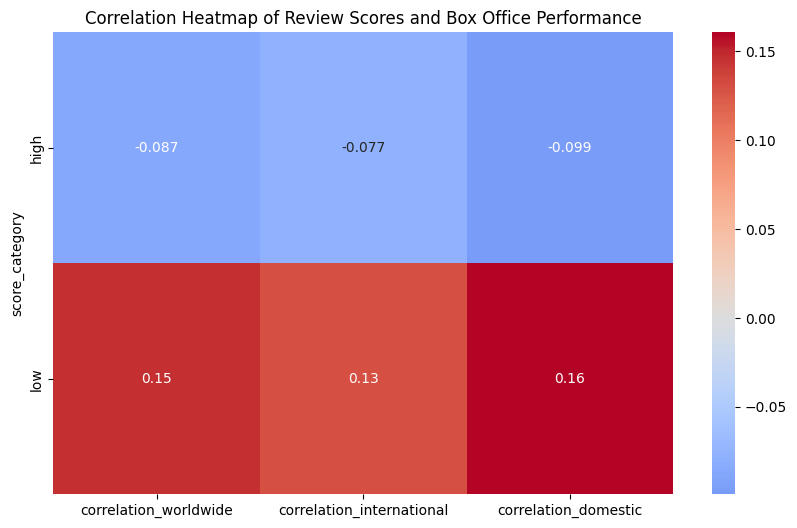

In [139]:
# Gwen visualising the correlation results into a heatmap
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = psycopg2.connect(
    host="localhost",
    database="postgres",  
    user="postgres",  
    password="Melvin10",  
    port="5432"
)

cur = conn.cursor()

correlation_query = """
WITH movie_data AS (
    SELECT 
        movie_box_office."title",
        movie_box_office."worldwide_box_office",
        movie_box_office."international_box_office",
        movie_box_office."domestic_box_office",
        CASE 
            WHEN user_avg_scores.average_score >= 70 THEN 'high'
            ELSE 'low'
        END AS score_category,
        user_avg_scores.average_score
    FROM (
        SELECT 
            "title",
            "worldwide_box_office",
            "international_box_office",
            "domestic_box_office"
        FROM public."movie"
    ) AS movie_box_office
    INNER JOIN (
        SELECT 
            "title", 
            ROUND(AVG("idvscore"), 0) AS average_score
        FROM public."Review"
        WHERE "role" = 'user'
        GROUP BY "title"
    ) AS user_avg_scores
    ON movie_box_office."title" = user_avg_scores."title"
)
SELECT 
    score_category,
    corr(movie_data.average_score, movie_data.worldwide_box_office) AS correlation_worldwide,
    corr(movie_data.average_score, movie_data.international_box_office) AS correlation_international,
    corr(movie_data.average_score, movie_data.domestic_box_office) AS correlation_domestic
FROM movie_data
GROUP BY score_category;
"""

cur.execute(correlation_query)
correlation_results = cur.fetchall()


correlation_df = pd.DataFrame(correlation_results, columns=["score_category", "correlation_worldwide", "correlation_international", "correlation_domestic"])

cur.close()
conn.close()

# Gwen reshape the DataFrame for heatmap
correlation_matrix = correlation_df.set_index('score_category')

# Gwen create heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation Heatmap of Review Scores and Box Office Performance')
plt.show()
